<a href="https://colab.research.google.com/github/Aris-cyber600/IPS/blob/main/IPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [3]:
#εγκατάσταση πακέτου tensorflow (hhttps://www.tensorflow.org/)
!pip install tensorflow
#εγκατάσταση πακέτου scikit-learn (https://scikit-learn.org/)
!pip install scikit-learn

In [4]:
#εισαγωγή βιβλιοθηκών - πακέτων
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [5]:
#συνάρτηση εισαγωγής συνόλου δεδομένων
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    X = df.drop('target', axis=1).values
    y = df['target'].values
    return X, y

In [6]:
#συνάρτηση δημιουργίας και εκπαίδευσης νευρωνικού δικτύου
def create_and_train_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [7]:
#συνάρτηση αξιολόγησης μοντέλου και εκτύπωσης αποτελέσματων κατηγοριοποίησης
def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    accuracy = classification_report(y_test, y_pred, output_dict=True)
    return accuracy['accuracy']

In [8]:
#συνάρτηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μετά από πλήθος ροών δεδομένων (streaming lambda architecture with periodic retraining)
def simulate_streaming_lambda_architecture(csv_file_path, model, scaler, batch_size=500, retrain_every_batches=800, total_batches=8000):
    batch_counter = 0
    train_accuracies = []
    test_accuracies = []

    while batch_counter < total_batches:
        #φόρτωση συνόλου δεδομένων από csv αρχείο
        X, y = load_dataset(csv_file_path)

        #τυποποίηση (standardize) δεδομένων
        X = scaler.transform(X)

        #κατάτμηση δεδομένων σε ροές (batches)
        for i in range(0, len(X), batch_size):
            batch_counter += 1
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]

            #εκπαίδευση μοντέλου με κάθε ροή δεδομένων
            model.train_on_batch(X_batch, y_batch)

            #περιοδική εκπαίδευση μοντέλου με όλα τα δεδομένα
            if batch_counter % retrain_every_batches == 0:
                #τμηματοποίηση δεδομένων σε σύνολα εκπαίδευσης και δοκιμών
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

                #επανεκπαίδευση μοντέλου με όλα τα δεδομένα
                model = create_and_train_model(X_train.shape[1])
                model.fit(X_train, y_train, epochs=5, batch_size=64)  # Train for a few epochs

                #αποθήκευση των βαρών (weights) του μοντέλου για μελλοντική επανεκπαίδευση
                model.save('model_weights.keras')

                #αξιολόγηση του μοντέλου στα σύνολα εκπαίδευσης και δοκιμών
                train_accuracy = evaluate_model(model, X_train, y_train)
                test_accuracy = evaluate_model(model, X_test, y_test)

                train_accuracies.append(train_accuracy)
                test_accuracies.append(test_accuracy)

                print(f"Batch {batch_counter}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    #εκτύπωση γραφικής απεικόνισης ακρίβειας μοντέλου
    plt.plot(range(1, total_batches+1, retrain_every_batches), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, total_batches+1, retrain_every_batches), test_accuracies, label='Test Accuracy')
    plt.xlabel('Batch Number')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy Over Batches')
    plt.legend()
    plt.show()


In [9]:
#θέση αρχείου csv με το σύνολο δεδομένων
csv_file_path = 'https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/pcap_data.csv'


In [10]:
#τυποποίηση (standardize) δεδομένων
scaler = StandardScaler()

In [11]:
#φόρτωση συνόλου δεδομένων
X, y = load_dataset(csv_file_path)
X = scaler.fit_transform(X)

In [12]:
#εκπαίδευση μοντέλου
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
model = create_and_train_model(X_train.shape[1])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6313 - loss: 0.8208
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8472 - loss: 0.4961
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8654 - loss: 0.4578
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8842 - loss: 0.4182
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8873 - loss: 0.4169
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 800, Training Accuracy: 0.9146, Test Accuracy: 0.9038
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6500 - loss: 0.8025
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8494 - loss: 0.4846
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8747 - loss: 0.4464
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8908 - loss: 0.4094
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8957 - loss: 0.3975
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 1600, Training Accuracy: 0.9136, Test Accuracy: 0.9025
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6512 - loss: 0.7979
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8528 - loss: 0.4798
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8765 - loss: 0.4358
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8821 - loss: 0.4310
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8863 - loss: 0.4268
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 2400, Training Accuracy: 0.9157, Test Accuracy: 0.9051
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6358 - loss: 0.7981
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8526 - loss: 0.4780
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8745 - loss: 0.4408
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8862 - loss: 0.4277
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8924 - loss: 0.4035
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 3200, Training Accuracy: 0.9141, Test Accuracy: 0.9015
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6332 - loss: 0.8169
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8464 - loss: 0.4932
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8662 - loss: 0.4574
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8816 - loss: 0.4232
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8945 - loss: 0.3989
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 4000, Training Accuracy: 0.9162, Test Accuracy: 0.9015
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6464 - loss: 0.7976
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8505 - loss: 0.4834
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8704 - loss: 0.4536
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8842 - loss: 0.4298
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8950 - loss: 0.4005
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 4800, Training Accuracy: 0.9132, Test Accuracy: 0.9031
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6370 - loss: 0.8156
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8485 - loss: 0.4938
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8695 - loss: 0.4531
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8909 - loss: 0.4012
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8885 - loss: 0.4135
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 5600, Training Accuracy: 0.9163, Test Accuracy: 0.9068
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6463 - loss: 0.7990
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8548 - loss: 0.4798
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8729 - loss: 0.4490
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8860 - loss: 0.4268
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8915 - loss: 0.4119
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 6400, Training Accuracy: 0.9138, Test Accuracy: 0.9038
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6336 - loss: 0.8073
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8497 - loss: 0.4857
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8703 - loss: 0.4446
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8891 - loss: 0.4148
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8864 - loss: 0.4191
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Batch 7200, Training Accuracy: 0.9150, Test Accuracy: 0.9055
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6473 - loss: 0.8024
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8450 - loss: 0.5021
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8780 - loss: 0.4442
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8866 - loss: 0.4287
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8925 - loss: 0.4062
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Batch 8000, Training Accuracy: 0.9161, Test Accuracy: 0.9048


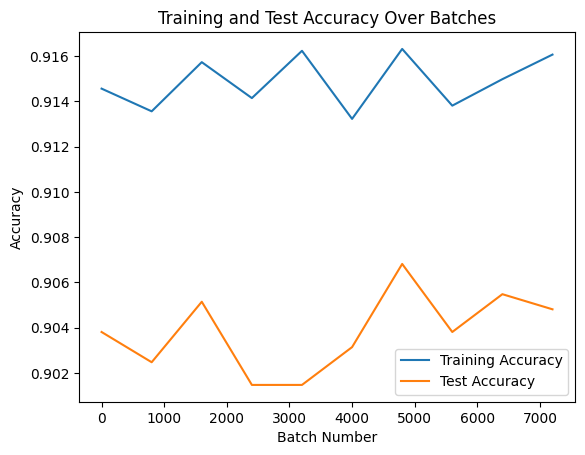

In [13]:
#εκκίνηση προσομοίωσης "λ" αρχιτεκτονικής με επανεκπαίδευση μοντέλου
simulate_streaming_lambda_architecture(csv_file_path, model, scaler)

In [14]:

#εισαγωγή βιβλιοθηκών - πακέτων
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer
import requests
from io import BytesIO
import gzip
import numpy as np

In [15]:
#κατέβασμα και αποσυμπίεση του συνόλου δεδομένων KDD Cup 1999
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
response = requests.get(url, stream=True)
compressed_file = BytesIO(response.content)
decompressed_file = gzip.GzipFile(fileobj=compressed_file)


In [16]:
#φόρτωση του συνόλου δεδομένων
columns = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land",
           "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in", "num_compromised",
           "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
           "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
           "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
           "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
           "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
           "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
           "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "target"]

df = pd.read_csv(decompressed_file, header=None, names=columns)

In [17]:
#δημιουργία του συνόλου σε δύο κλάσεις Normal (0) και Attack (1)
X = df.drop("target", axis=1)
y = df["target"].apply(lambda x: 0 if x == "normal." else 1)


In [18]:
#έλεγχος κλάσεων
print("Κατανομή κλάσεων y:")
print(y.value_counts())

Κατανομή κλάσεων y:
target
1    396743
0     97278
Name: count, dtype: int64


In [19]:
#εντοπισμός κατηγορικών μεταβλητών
categorical_features = ['protocol_type', 'service', 'flag']

In [20]:

#διαχωρισμός κατηγορικών και αριθμητικών μεταβλητών
numeric_features = X.columns.difference(categorical_features)

In [21]:

#δημιουργία διοχέτευσης (αγωγού) προεπεξεργασίας με κωδικοποίηση μίας δέσμης (one-hot encoding) για κατηγορικές μεταβλητές
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [22]:
#τμηματοποίηση δεδομένων σε σύνολα εκαπίδευσης και δοκιμών
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
#δημιουργία διοχέτευσης (αγωγού) SMOTE για τις αριθμητικές μεταβλητές μόνο
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTENC(random_state=42, categorical_features=[X.columns.get_loc(col) for col in categorical_features])),
    ('classifier', RandomForestClassifier(random_state=42))
])


In [24]:
#καθορισμός κατωφλίου (threshold) για την διακοπή διακτυακής κίνησης
blocking_threshold = 0.9

In [31]:
#δημιουργία βρόχου συνεχούς - αυξητικής μάθησης
batch_size = 10000
for epoch in range(1, 3):  #δυνατότητα αλλαγής των εποχών
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train.iloc[i:i + batch_size]
        y_batch = y_train.iloc[i:i + batch_size]

        #σταδιακή ενημέρωση του μοντέλου με κάθε ροή (batch) δεδομένων
        pipeline.fit(X_batch, y_batch)

        #περιοδική ενημέρωση του μοντέλου στο σύνολο δοκιμών
        if i % batch_size == 0 and i > 0:
            y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

            #αποκλεισμός δικτυακής κυκλοφορίας εάν η προβλεπόμενη πιθανότητα υπερβαίνει το καθορισμένο όριο
            blocked_indices = np.where(y_pred_proba > blocking_threshold)[0]
            if len(blocked_indices) > 0:
                print(f"Blocking {len(blocked_indices)} malicious traffic instances.")

            accuracy = accuracy_score(y_test, y_pred_proba > blocking_threshold)
            print(f"Epoch {epoch}, Iteration {i}, Test Accuracy: {accuracy}")


Blocking 118380 malicious traffic instances.
Epoch 1, Iteration 10000, Test Accuracy: 0.9957154520366784
Blocking 118206 malicious traffic instances.
Epoch 1, Iteration 20000, Test Accuracy: 0.9945414184215321
Blocking 118321 malicious traffic instances.
Epoch 1, Iteration 30000, Test Accuracy: 0.995317360178669
Blocking 118405 malicious traffic instances.
Epoch 1, Iteration 40000, Test Accuracy: 0.9958841350273604
Blocking 118424 malicious traffic instances.
Epoch 1, Iteration 50000, Test Accuracy: 0.9960123341002787
Blocking 118137 malicious traffic instances.
Epoch 1, Iteration 60000, Test Accuracy: 0.9940758533672499
Blocking 118123 malicious traffic instances.
Epoch 1, Iteration 70000, Test Accuracy: 0.993981390892468
Blocking 118434 malicious traffic instances.
Epoch 1, Iteration 80000, Test Accuracy: 0.9960798072965514
Blocking 118330 malicious traffic instances.
Epoch 1, Iteration 90000, Test Accuracy: 0.9953780860553145
Blocking 118272 malicious traffic instances.
Epoch 1, Ite

In [33]:
#τελική αξιολόγηση του μοντέλου στο σύνολο δοκιμών
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
blocked_indices = np.where(y_pred_proba > blocking_threshold)[0]

# Simulate device isolation
if len(blocked_indices) > 0:
    print(f"Blocking {len(blocked_indices)} malicious traffic instances.")
    # In a real IPS, you would implement device isolation here.
    # For simulation purposes, we'll just print the indices of affected instances.
    # print(f"Simulating isolation of devices corresponding to indices: {blocked_indices}")

    # Simulate administrator notification for automated intervention
    print(f"Sending alert to administrators: {len(blocked_indices)} potential malicious traffic instances detected requiring automated intervention.")


accuracy = accuracy_score(y_test, y_pred_proba > blocking_threshold)
classification_rep = classification_report(y_test, y_pred_proba > blocking_threshold)

Blocking 118164 malicious traffic instances.
Sending alert to administrators: 118164 potential malicious traffic instances detected requiring automated intervention.


In [34]:
#εκτύπωση τελικών αποτελεσμάτων
print(f"Final Test Accuracy: {accuracy}")
print("Classification Report:")
print(classification_rep)


Final Test Accuracy: 0.9942580309971863
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     29192
           1       1.00      0.99      1.00    119015

    accuracy                           0.99    148207
   macro avg       0.99      1.00      0.99    148207
weighted avg       0.99      0.99      0.99    148207



,precision,recall,f1-score,support
0,0.971674,1.000000,0.985633,29192.000000
1,1.000000,0.992850,0.996412,119015.000000
accuracy,0.994258,0.994258,0.994258,0.994258
macro avg,0.985837,0.996425,0.991023,148207.000000
weighted avg,0.994421,0.994258,0.994289,148207.000000


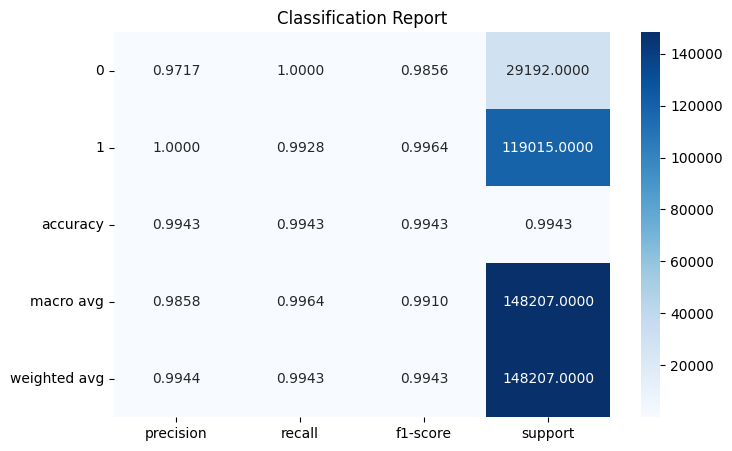

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming classification_rep is already calculated and is a dictionary as returned by sklearn.metrics.classification_report(output_dict=True)
# If not, recalculate it with output_dict=True in the cell where you generate the report.
# Example: classification_rep = classification_report(y_test, y_pred_proba > blocking_threshold, output_dict=True)

# Convert the classification report dictionary to a pandas DataFrame for better visualization
classification_df = pd.DataFrame(classification_rep).transpose()

# Display the DataFrame
display(classification_df)

# Optional: Visualize as a heatmap for a more graphical representation
plt.figure(figsize=(8, 5))
sns.heatmap(classification_df[['precision', 'recall', 'f1-score', 'support']], annot=True, cmap='Blues', fmt=".4f")
plt.title('Classification Report')
plt.show()